# Unsupervised exploration of Corona dataset

In [1]:
import numpy as np
import scipy as sp
import pystan
import arviz
import matplotlib.pyplot as plt
from scipy.stats import norm
import csv
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.cm as cm
%matplotlib inline

## Problem

Model the Corona dataset. Each data point is a 2d vector which includes: (x,y) where x indicates the day and y indicates the percentage of the positive results per day. 

## Data

Load the Corona dataset:

In [2]:
DATA = "data/corona.csv"
data = []
with open(DATA) as f:
    rdr = csv.reader(f)
    next(rdr)
    for i, rec in enumerate(rdr):
        _, tests, results = str(rec[0]), float(rec[1]), float(rec[2])
        data.append([i, float(results/tests)])

data = np.array(data) # (105, 2)
data_for_model = {'N':len(data), 'y': data[:,1], 'x': data[:,0]}

#print(data.shape)
#print(data)

## Data exploration:

Here we show a scatter of the observations: % of positive cases per day.


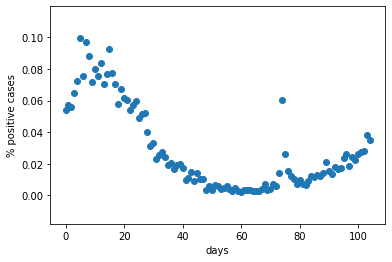

In [3]:
plt.scatter(data[:,0], data[:,1])
plt.xlabel("days")
plt.ylabel("% positive cases")
plt.show()

## Model

Here we introduce our model: Bayesian linear regression.<br>
We assume that the data is periodic, thus we use sine and cosines functions on x.

In [4]:
model_1 = """
data {
  int<lower=0> N;
  vector[N] y;
  vector[N] x;
}
parameters {
  real beta1;
  real beta2;
  real beta3;
  real beta4;
  real<lower=0> sigma;
}
model {
  beta1 ~ normal(0,0.1);
  beta2 ~ normal(0,0.1);
  beta3 ~ normal(0,0.1);
  beta4 ~ normal(0,0.1);
  sigma ~ normal(0,0.001);
  
  for (n in 1:N)
    y[n] ~ normal(beta1 * sin(3.1415*x[n]/135) * sin(3.1415*x[n]/135) 
            + beta2 * cos(3.1415*x[n]/135) * cos(3.1415*x[n]/135) 
            + beta3 * sin(2*3.1415*x[n]/135) * sin(2*3.1415*x[n]/135) 
            + beta4 * cos(2*3.1415*x[n]/135) * cos(2*3.1415*x[n]/135), sigma);
}
"""

model_2 = """
data {
  int<lower=0> N;
  vector[N] y;
  vector[N] x;
}
parameters {
  real beta1;
  real beta2;
  real beta3;
  real beta4;
  real beta5;
  real beta6;
  real<lower=0> sigma;
}
model {
  beta1 ~ normal(0,0.1);
  beta2 ~ normal(0,0.1);
  beta3 ~ normal(0,0.1);
  beta4 ~ normal(0,0.1);
  beta5 ~ normal(0,0.1);
  beta6 ~ normal(0,0.1);
  sigma ~ normal(0,0.001);
  
  for (n in 1:N)
    y[n] ~ normal(beta1 * sin(3.1415*x[n]/135) * sin(3.1415*x[n]/135) 
            + beta2 * cos(3.1415*x[n]/135) * cos(3.1415*x[n]/135) 
            + beta3 * sin(2*3.1415*x[n]/135) * sin(2*3.1415*x[n]/135) 
            + beta4 * cos(2*3.1415*x[n]/135) * cos(2*3.1415*x[n]/135)
            + beta5 * sin(3*3.1415*x[n]/135) * sin(3*3.1415*x[n]/135) 
            + beta6 * cos(3*3.1415*x[n]/135) * cos(3*3.1415*x[n]/135), sigma);
}
"""

In [5]:
model_1 = pystan.StanModel(model_code=model_1)
model_2 = pystan.StanModel(model_code=model_2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f5c78ffe55cb97246146f0c4f4657ac7 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c084cedc93995274d8b3bf22b0d79577 NOW.


## Inference and Analyse

Collect samples from the posterior of model 1:

Inference for Stan model: anon_model_f5c78ffe55cb97246146f0c4f4657ac7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
beta1  -0.02  2.6e-3   0.05  -0.11   -0.05  -0.02   0.01   0.07    333   1.01
beta2   0.06  2.6e-3   0.05  -0.03    0.02   0.06   0.09   0.15    333   1.01
beta3   0.01  2.6e-3   0.05  -0.08   -0.02   0.01   0.04    0.1    333   1.01
beta4   0.03  2.6e-3   0.05  -0.06 -8.2e-3   0.03   0.06   0.11    332   1.01
sigma 7.7e-3  1.5e-5 3.7e-4 7.0e-3  7.4e-3 7.6e-3 7.9e-3 8.4e-3    630    1.0
lp__  395.05    0.06   1.52 391.17   394.3 395.35 396.19 397.02    580   1.01

Samples were drawn using NUTS at Tue Jul 14 21:39:56 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


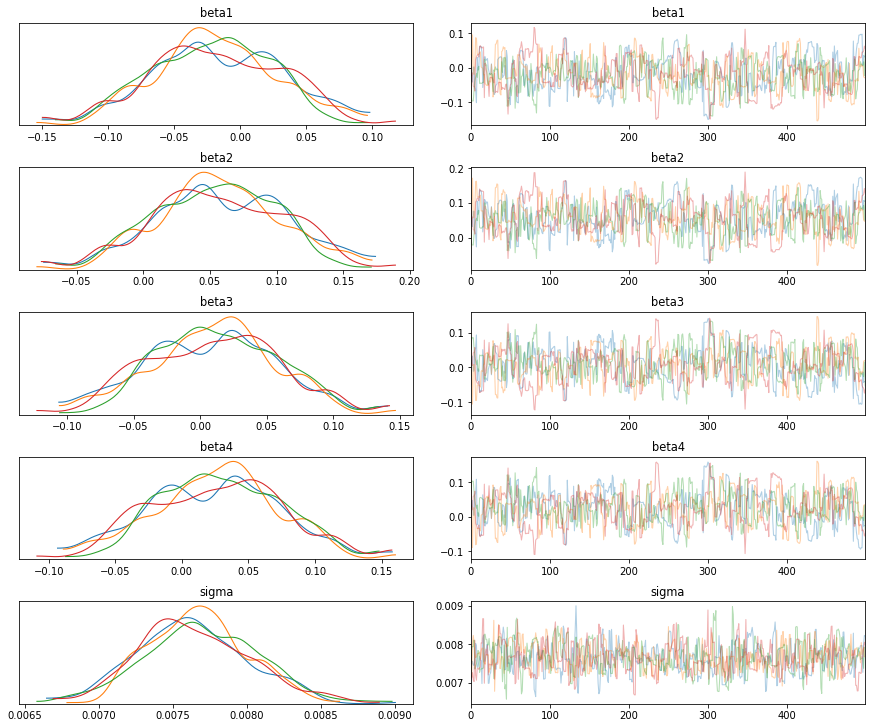

In [6]:
iterations = 1000
fit_1 = model_1.sampling(data=data_for_model, iter=iterations, chains=4, init=lambda: {'beta1': 0, 'beta1': 0, 'beta2': 0, 'beta3': 0, 'beta4': 0, 'sigma': 0.1})
print(fit_1)
_ = arviz.plot_trace(fit_1)

Collect samples from the posterior of model 2:

Inference for Stan model: anon_model_c084cedc93995274d8b3bf22b0d79577.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1  -0.03  2.4e-3   0.06  -0.14  -0.07  -0.03   0.01   0.08    595    1.0
beta2   0.05  2.4e-3   0.06  -0.06 6.2e-3   0.05   0.09   0.16    595    1.0
beta3 6.2e-4  2.4e-3   0.06  -0.11  -0.04 7.7e-4   0.04   0.12    569   1.01
beta4   0.01  2.4e-3   0.06  -0.09  -0.02   0.01   0.05   0.13    568   1.01
beta5   0.02  2.2e-3   0.06  -0.09  -0.01   0.02   0.06   0.13    616    1.0
beta6   0.01  2.2e-3   0.06   -0.1  -0.02   0.02   0.05   0.12    617    1.0
sigma 7.4e-3  1.3e-5 3.6e-4 6.7e-3 7.2e-3 7.4e-3 7.7e-3 8.2e-3    771    1.0
lp__   401.3    0.07   1.86 396.62 400.32 401.64 402.68 404.01    661   1.01

Samples were drawn using NUTS at Tue Jul 14 21:40:12 2020.
For each parameter, n_eff is a crude measure of effective sa

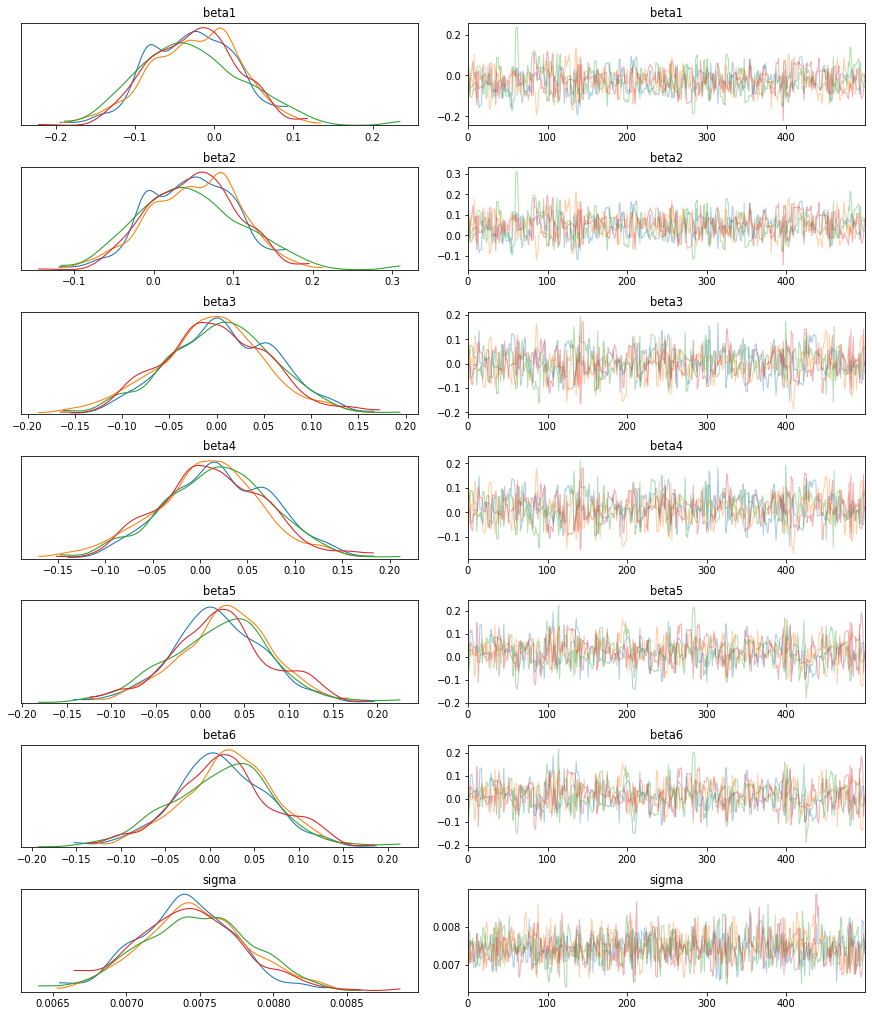

In [7]:
iterations = 1000
fit_2 = model_2.sampling(data=data_for_model, iter=iterations, chains=4, init=lambda: {'beta1': 0, 'beta1': 0, 'beta2': 0, 'beta3': 0, 'beta4': 0, 'beta5': 0, 'beta6': 0, 'sigma': 0.1})
print(fit_2)
_ = arviz.plot_trace(fit_2)

Here we show samples of the regression function, overlaid with a scatter of the observations:

In [8]:
def regression_sample_1(x, coeffs):
    y = coeffs[1] * np.sin(x*3.1415/135)**2 + coeffs[2] * np.cos(x*3.1415/135)**2 + coeffs[3] * np.sin(x*2*3.1415/135)**2 + coeffs[4] * np.cos(x*2*3.1415/135)**2  
    return y

def regression_sample_2(x, coeffs):
    y = coeffs[1] * np.sin(x*3.1415/135)**2 + coeffs[2] * np.cos(x*3.1415/135)**2 + coeffs[3] * np.sin(x*2*3.1415/135)**2 + coeffs[4] * np.cos(x*2*3.1415/135)**2 + coeffs[5] * np.sin(x*3*3.1415/135)**2 + coeffs[6] * np.cos(x*3*3.1415/135)**2  
    return y


In [9]:
x = np.linspace(0, 135, 135)
beta1_1 = fit_1.extract(['beta1'])['beta1']
beta2_1 = fit_1.extract(['beta2'])['beta2']
beta3_1 = fit_1.extract(['beta3'])['beta3']
beta4_1 = fit_1.extract(['beta4'])['beta4']

x = np.linspace(0, 135, 135)
beta1_2 = fit_2.extract(['beta1'])['beta1']
beta2_2 = fit_2.extract(['beta2'])['beta2']
beta3_2 = fit_2.extract(['beta3'])['beta3']
beta4_2 = fit_2.extract(['beta4'])['beta4']
beta5_2 = fit_2.extract(['beta5'])['beta5']
beta6_2 = fit_2.extract(['beta6'])['beta6']
fig, ax = plt.subplots(1,2, figsize=(20, 7))


#colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

num_colors = 80;
colors = cm.rainbow(np.linspace(0,1,num_colors))

num_of_simulated_reg = beta1_1.shape[0]
for i in range(num_of_simulated_reg):
    indc = np.random.randint(0, len(colors))
    coeffs_sample_1 = [beta1_1[i], beta1_1[i], beta2_1[i], beta3_1[i], beta4_1[i]]
    coeffs_sample_2 = [beta1_2[i], beta1_2[i], beta2_2[i], beta3_2[i], beta4_2[i], beta5_2[i], beta6_2[i]]
    ax[0].plot(x, regression_sample_1(x, coeffs_sample_1), color=colors[indc], linewidth=0.3, zorder=1)
    ax[1].plot(x, regression_sample_2(x, coeffs_sample_2), color=colors[indc], linewidth=0.3, zorder=1)
ax[0].scatter(data[:,0], data[:,1], color='black', s=7, zorder=2)
ax[1].scatter(data[:,0], data[:,1], color='black', s=7, zorder=2)


ax[0].title.set_text("model_1")
ax[1].title.set_text("model_2")
plt.show()



## Model Checking

**Log probability:**<br>
Here we plot the posterior distribution of the log predictive density log p(y|theta).

In [10]:
logp_model = fit_1.extract()['lp__']

fig, ax = plt.subplots(1,2, figsize=(20, 7))
ax[0].set_xlabel("logp")

ax[0].set_yscale("log")
ax[0].hist(logp_model)
ax[0].title.set_text("model_1")

logp_model = fit_2.extract()['lp__']

ax[1].set_xlabel("logp")
ax[1].set_yscale("log")
ax[1].hist(logp_model)
ax[1].title.set_text("model_2")

plt.show()

**Generate a replications (y_rep) of the dataset:**<br>
We generate replications of the dataset. Each replication of the data (simulation) is generated in the following way:<br>
We sample 105 sets of the model's parameters (beta1, ..., beta4, sigma), and for each sample, we draw y_i and get 105 replicated observations.<br>
We perform 8 such simulations, and plot each simulation as a scatter plot. We also plot the scatter of the real observations. 

In [11]:
def sample_yrep_1(x, coeffs, sigma):
    mu = regression_sample_1(x,coeffs)
    return np.random.normal(mu, sigma)

In [12]:
def sample_yrep_2(x, coeffs, sigma):
    mu = regression_sample_2(x,coeffs)
    return np.random.normal(mu, sigma)

Samples from model_1

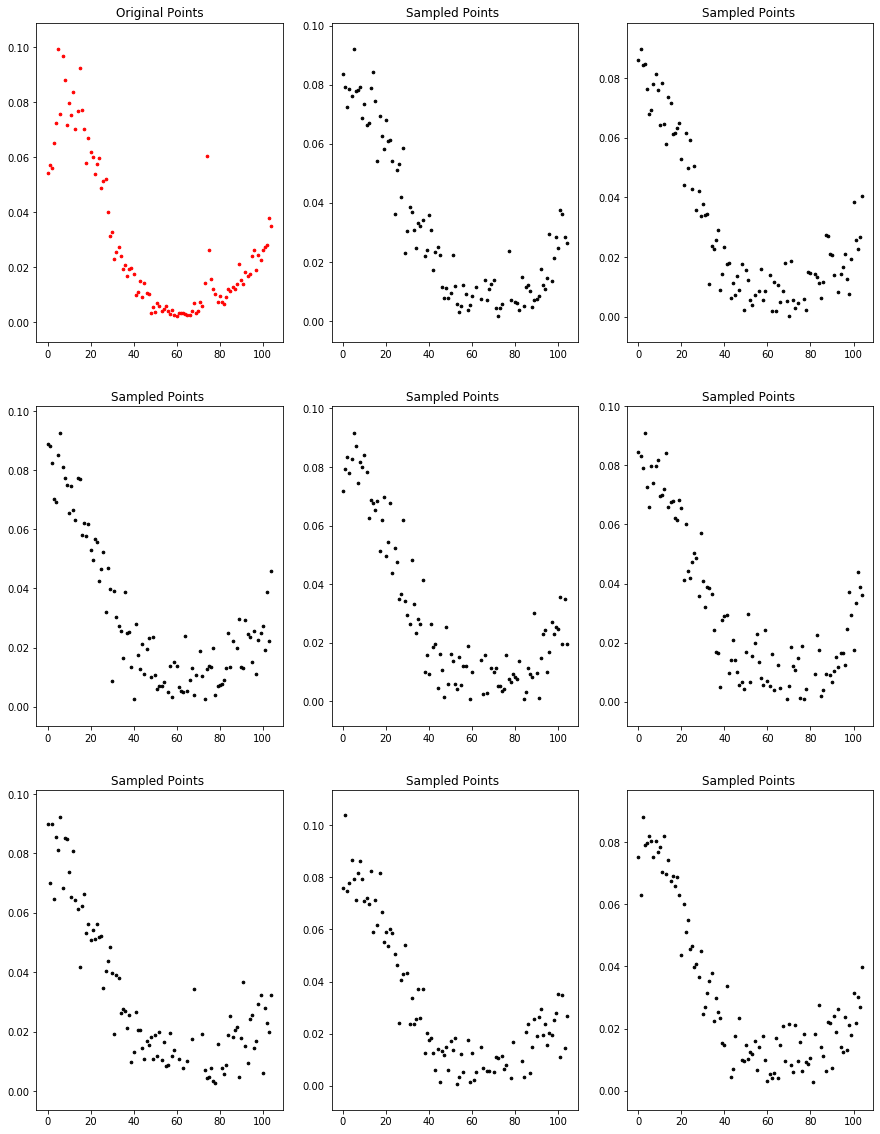

In [13]:
x = np.linspace(0, 105, 105)
beta1_1 = fit_1.extract(['beta1'])['beta1']
beta2_1 = fit_1.extract(['beta2'])['beta2']
beta3_1 = fit_1.extract(['beta3'])['beta3']
beta4_1 = fit_1.extract(['beta4'])['beta4']

sigma_1 = fit_1.extract(['sigma'])['sigma']
fig, ax = plt.subplots(3,3, figsize=(15, 20))


for j in range(8):
    y_rep = np.zeros((105,2))
    for i in range(105):
        ind = np.random.randint(0, beta1_1.shape[0])
        coeffs_sample_1 = [beta1_1[i], beta1_1[i], beta2_1[i], beta3_1[i], beta4_1[i]]
        y_rep[i,0] = i
        
        y_rep[i,1] = sample_yrep_1(i, coeffs_sample_1, sigma_1[ind])

    # remove negative values:
    y_rep = y_rep[y_rep[:,1]>0]
    ax[(j+1)//3][(j+1)%3].scatter(y_rep[:,0], y_rep[:,1], color='black', s=7, zorder=2)
    ax[(j+1)//3][(j+1)%3].title.set_text("Sampled Points "+str())
ax[0][0].scatter(data[:,0], data[:,1], color='red', s=7, zorder=2)
ax[0][0].title.set_text("Original Points")

Samples from model_2

In [14]:
x = np.linspace(0, 105, 105)
beta1_2 = fit_2.extract(['beta1'])['beta1']
beta2_2 = fit_2.extract(['beta2'])['beta2']
beta3_2 = fit_2.extract(['beta3'])['beta3']
beta4_2 = fit_2.extract(['beta4'])['beta4']
beta5_2 = fit_2.extract(['beta5'])['beta5']
beta6_2 = fit_2.extract(['beta6'])['beta6']
sigma_2 = fit_2.extract(['sigma'])['sigma']
fig, ax = plt.subplots(3,3, figsize=(15, 20))

for j in range(8):
    y_rep = np.zeros((105,2))
    for i in range(105):
        ind = np.random.randint(0, beta1_1.shape[0])
        coeffs_sample_2 = [beta1_2[i], beta1_2[i], beta2_2[i], beta3_2[i], beta4_2[i], beta5_2[i], beta6_2[i]]
        y_rep[i,0] = i
        
        y_rep[i,1] = sample_yrep_2(i, coeffs_sample_2, sigma_1[ind])

    # remove negative values:
    y_rep = y_rep[y_rep[:,1]>0]
    ax[(j+1)//3][(j+1)%3].scatter(y_rep[:,0], y_rep[:,1], color='black', s=7, zorder=2)
    ax[(j+1)//3][(j+1)%3].title.set_text("Sampled Points "+str())
ax[0][0].scatter(data[:,0], data[:,1], color='red', s=7, zorder=2)
ax[0][0].title.set_text("Original Points")

**P-Value:**<br>
Here we compute p-value for the following test statistics: min, max and median values over all 105 observations / replicated observations.<br>
We sample 105 sets of the model's parameters (beta1, ..., beta4, sigma), and for each sample, we draw y_i and get 105 replicated observations.<br>
We perform S such simulations, and on each replicated set we compute min, max and median values.<br>
We then plot the histograms of the min, max and median of the replicated data along with the real observation results (red line), and the p-values for each of the test statistics.

Model_1

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(17, 3))
fig.subplots_adjust(top=1.5)

S = 10000 # number of samples

ax[0].set_xlabel("min")
ax[1].set_xlabel("max")
ax[2].set_xlabel("median")

# Compute min, max and median from the real data:
dataMin, dataMax, dataMedian = np.min(data[:,1]), np.max(data[:,1]), np.median(data[:,1])
#print(dataMin, dataMax, dataMedian)


# Compute min, max and median from the replicated data:
rep_min = np.zeros(S)
rep_max = np.zeros(S)
rep_median = np.zeros(S)
for j in range(S):
    y_rep = np.zeros((105,2))
    for i in range(105):
        ind = np.random.randint(0, beta1_1.shape[0])
        coeffs_sample_1 = [beta1_1[i], beta1_1[i], beta2_1[i], beta3_1[i], beta4_1[i]]

        y_rep[i,0] = i
        y_rep[i,1] = sample_yrep_1(i, coeffs_sample_1, sigma_1[ind])

    # remove negative values:
    y_rep = y_rep[y_rep[:,1]>0]
    
    rep_min[j] = np.min(y_rep[:,1])
    rep_max[j] = np.max(y_rep[:,1])
    rep_median[j] = np.median(y_rep[:,1])

    
# plot data values of test variables as vertical red lines
ax[0].axvline(dataMin, color="red")
ax[1].axvline(dataMax, color="red")
ax[2].axvline(dataMedian, color="red")

# plot sampled values of test values as histograms
ax[0].hist(rep_min, zorder=-1)
ax[1].hist(rep_max, zorder=-1)
ax[2].hist(rep_median, zorder=-1)

# compute p-values and display them as subplot titles
ax[0].set_title("p-value = {:.2f}".format(
    len(rep_min[rep_min < dataMin]) /
    len(rep_min)))
ax[1].set_title("p-value = {:.2f}".format(
    len(rep_max[rep_max > dataMax]) /
    len(rep_max)))
ax[2].set_title("p-value = {:.2f}".format(
    len(rep_median[rep_median < dataMedian]) /
    len(rep_median)))

plt.show()

Model_2

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(17, 3))
fig.subplots_adjust(top=1.5)

S = 10000 # number of samples

ax[0].set_xlabel("min")
ax[1].set_xlabel("max")
ax[2].set_xlabel("median")

# Compute min, max and median from the real data:
dataMin, dataMax, dataMedian = np.min(data[:,1]), np.max(data[:,1]), np.median(data[:,1])
#print(dataMin, dataMax, dataMedian)


# Compute min, max and median from the replicated data:
rep_min = np.zeros(S)
rep_max = np.zeros(S)
rep_median = np.zeros(S)
for j in range(S):
    y_rep = np.zeros((105,2))
    for i in range(105):
        ind = np.random.randint(0, beta1_2.shape[0])
        coeffs_sample_2 = [beta1_2[i], beta1_2[i], beta2_2[i], beta3_2[i], beta4_2[i], beta5_2[i], beta6_2[i]]

        y_rep[i,0] = i
        y_rep[i,1] = sample_yrep_2(i, coeffs_sample_2, sigma_2[ind])

    # remove negative values:
    y_rep = y_rep[y_rep[:,1]>0]
    
    rep_min[j] = np.min(y_rep[:,1])
    rep_max[j] = np.max(y_rep[:,1])
    rep_median[j] = np.median(y_rep[:,1])

    
# plot data values of test variables as vertical red lines
ax[0].axvline(dataMin, color="red")
ax[1].axvline(dataMax, color="red")
ax[2].axvline(dataMedian, color="red")

# plot sampled values of test values as histograms
ax[0].hist(rep_min, zorder=-1)
ax[1].hist(rep_max, zorder=-1)
ax[2].hist(rep_median, zorder=-1)

# compute p-values and display them as subplot titles
ax[0].set_title("p-value = {:.2f}".format(
    len(rep_min[rep_min < dataMin]) /
    len(rep_min)))
ax[1].set_title("p-value = {:.2f}".format(
    len(rep_max[rep_max > dataMax]) /
    len(rep_max)))
ax[2].set_title("p-value = {:.2f}".format(
    len(rep_median[rep_median < dataMedian]) /
    len(rep_median)))

plt.show()

# Model Evaluation

We compare between "model_1" and "model_2" using the WAIC measurement for the evaluation.

**Compute lppd:**

In [19]:
def compute_lppd(model):
    if model == "model_1":
        beta1_1 = fit_1.extract(['beta1'])['beta1']
        beta2_1 = fit_1.extract(['beta2'])['beta2']
        beta3_1 = fit_1.extract(['beta3'])['beta3']
        beta4_1 = fit_1.extract(['beta4'])['beta4']
        sigma = fit_1.extract(['sigma'])['sigma']
    else:
        beta1_2 = fit_2.extract(['beta1'])['beta1']
        beta2_2 = fit_2.extract(['beta2'])['beta2']
        beta3_2 = fit_2.extract(['beta3'])['beta3']
        beta4_2 = fit_2.extract(['beta4'])['beta4']
        beta5_2 = fit_2.extract(['beta5'])['beta5']
        beta6_2 = fit_2.extract(['beta6'])['beta6']
        sigma = fit_2.extract(['sigma'])['sigma']
                            
    lppd = 0
    for i in range(105):  # run on the observations
        tmp_sum = 0
        x, y = data[i, :]
        for j in range(sigma.shape[0]):  # run on samples:
            # On each theta^s, compute p(y|theta^s):
            if model == "model_1":
                coeffs = [beta1_1[i], beta1_1[i], beta2_1[i], beta3_1[i], beta4_1[i]]
                mu = regression_sample_1(x, coeffs)
            else:
                coeffs = [beta1_2[i], beta1_2[i], beta2_2[i], beta3_2[i], beta4_2[i], beta5_2[i], beta6_2[i]]
                mu = regression_sample_2(x, coeffs)
            
            tmp_sum = tmp_sum + norm.pdf(y, mu, sigma[j])

        lppd = lppd + np.log(tmp_sum / sigma.shape[0])

    return lppd

lppd_1 = compute_lppd("model_1")
lppd_2 = compute_lppd("model_2")
print("-2*lppd of model_1: ", -2*lppd_1)
print("-2*lppd of model_2: ", -2*lppd_2)

-2*lppd of model_1:  -676.0082952938362
-2*lppd of model_2:  -680.7006903329963


**Compute p_WAIC_1, p_WAIC_2, and WAIC:**

In [20]:
def compute_p_WAIC_1(model):
    if model == "model_1":
        beta1_1 = fit_1.extract(['beta1'])['beta1']
        beta2_1 = fit_1.extract(['beta2'])['beta2']
        beta3_1 = fit_1.extract(['beta3'])['beta3']
        beta4_1 = fit_1.extract(['beta4'])['beta4']
        sigma = fit_1.extract(['sigma'])['sigma']
    else:
        beta1_2 = fit_2.extract(['beta1'])['beta1']
        beta2_2 = fit_2.extract(['beta2'])['beta2']
        beta3_2 = fit_2.extract(['beta3'])['beta3']
        beta4_2 = fit_2.extract(['beta4'])['beta4']
        beta5_2 = fit_2.extract(['beta5'])['beta5']
        beta6_2 = fit_2.extract(['beta6'])['beta6']
        sigma = fit_2.extract(['sigma'])['sigma']
        
    res = 0
    for i in range(105):  # run on the observations
        tmp_sum_a = 0
        tmp_sum_b = 0
        x, y = data[i, :]
        for j in range(sigma.shape[0]):  # run on samples:
            # On each theta^s, compute p(y|theta^s):
            if model == "model_1":
                coeffs = [beta1_1[i], beta1_1[i], beta2_1[i], beta3_1[i], beta4_1[i]]
                mu = regression_sample_1(x, coeffs)
            else:
                coeffs = [beta1_2[i], beta1_2[i], beta2_2[i], beta3_2[i], beta4_2[i], beta5_2[i], beta6_2[i]]
                mu = regression_sample_2(x, coeffs)
                
            prob = norm.pdf(y, mu, sigma[j])
            tmp_sum_a = tmp_sum_a + prob
            tmp_sum_b = tmp_sum_b + np.log(prob)
            
        res = res + np.log(tmp_sum_a / sigma.shape[0]) - (tmp_sum_b / sigma.shape[0])
    
    return 2*res

p_WAIC_1_m1 = compute_p_WAIC_1("model_1")
p_WAIC_1_m2 = compute_p_WAIC_1("model_2")
print("p_WAIC_1 of model_1: ", p_WAIC_1_m1)
print("p_WAIC_1 of model_2: ", p_WAIC_1_m2)

p_WAIC_1 of model_1:  5.5379640585819745
p_WAIC_1 of model_2:  5.2877147809317195


In [21]:
def compute_p_WAIC_2(model):
    if model == "model_1":
        beta1_1 = fit_1.extract(['beta1'])['beta1']
        beta2_1 = fit_1.extract(['beta2'])['beta2']
        beta3_1 = fit_1.extract(['beta3'])['beta3']
        beta4_1 = fit_1.extract(['beta4'])['beta4']
        sigma = fit_1.extract(['sigma'])['sigma']
    else:
        beta1_2 = fit_2.extract(['beta1'])['beta1']
        beta2_2 = fit_2.extract(['beta2'])['beta2']
        beta3_2 = fit_2.extract(['beta3'])['beta3']
        beta4_2 = fit_2.extract(['beta4'])['beta4']
        beta5_2 = fit_2.extract(['beta5'])['beta5']
        beta6_2 = fit_2.extract(['beta6'])['beta6']
        sigma = fit_2.extract(['sigma'])['sigma']
              
    avg = []
    for i in range(105):  # run on the observations
        tmp_sum = 0
        tmp_cnt = 0
        x, y = data[i, :]
        for j in range(sigma.shape[0]):  # run on samples:
            # On each theta^s, compute p(y|theta^s):
            if model == "model_1":
                coeffs = [beta1_1[i], beta1_1[i], beta2_1[i], beta3_1[i], beta4_1[i]]
                mu = regression_sample_1(x, coeffs)
            else:
                coeffs = [beta1_2[i], beta1_2[i], beta2_2[i], beta3_2[i], beta4_2[i], beta5_2[i], beta6_2[i]]
                mu = regression_sample_2(x, coeffs)
                
            prob = norm.pdf(y, mu, sigma[j])
            
            tmp_sum = tmp_sum + np.log(prob)
            tmp_cnt = tmp_cnt + 1
            
        avg.append(tmp_sum/tmp_cnt)
    
    res = 0
    for i in range(105):  # run on the observations
        tmp_sum = 0
        x, y = data[i, :]
        for j in range(sigma.shape[0]):  # run on samples:
            # On each theta^s, compute p(y|theta^s):
            if model == "model_1":
                coeffs = [beta1_1[i], beta1_1[i], beta2_1[i], beta3_1[i], beta4_1[i]]
                mu = regression_sample_1(x, coeffs)
            else:
                coeffs = [beta1_2[i], beta1_2[i], beta2_2[i], beta3_2[i], beta4_2[i], beta5_2[i], beta6_2[i]]
                mu = regression_sample_2(x, coeffs)
                
            prob = norm.pdf(y, mu, sigma[j])
            
            tmp_sum = tmp_sum + ((np.log(prob) - avg[i]) ** 2)
            
        res = res + ((1/(sigma.shape[0]-1)) * tmp_sum)
    
    return 2*res

p_WAIC_2_m1 = compute_p_WAIC_2("model_1")
p_WAIC_2_m2 = compute_p_WAIC_2("model_2")
print("p_WAIC_2 of model_1: ", p_WAIC_2_m1)
print("p_WAIC_2 of model_2: ", p_WAIC_2_m2)

p_WAIC_2 of model_1:  12.838951824791893
p_WAIC_2 of model_2:  12.323386534420262


In [22]:
WAIC_1 = -2 * (lppd_1 - p_WAIC_2_m1)
WAIC_2 = -2 * (lppd_2 - p_WAIC_2_m2)
print("WAIC of model_1: ", WAIC_1)
print("WAIC of model_2: ", WAIC_2)

WAIC of model_1:  -650.3303916442525
WAIC of model_2:  -656.0539172641558
